# Scraping Ligue 1 data from their website.

In this workbook, I retrieve player data from [ligue1.com](https://ligue1.com/en/data-zone/ligue1mcdonalds) updated as at 20/11/2025.
I also create a few visualizations to show examples of what this data could be used to do.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import time, re, requests, random
from io import StringIO
import pickle
from mplsoccer import add_image
from matplotlib.offsetbox import OffsetBox, AnnotationBbox, OffsetImage
from urllib.request import urlopen
from PIL import Image
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#details for where the player data can be found
url = "https://ma-api.ligue1.fr/championship-players-advanced-rankings/1/top?"
header = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/142.0.0.0 Safari/537.36"}
response = requests.get(url, headers=header)
print(response.status_code) #code 200 means we have an all clear

#storing the json data into a python variable
l1_data = response.json()

200


In [3]:
#getting club information
club_id_url = "https://ma-api.ligue1.fr/championship-clubs"
club_resp = requests.get(club_id_url, headers=header)
club_id = club_resp.json()

In [4]:
#all player statistics that have been collected
for stat in l1_data['rankings'].keys():
    print(stat)

goals
assists
expectedGoals
cleanSheets
minutesPlayed
contestsWon
shotsOnTarget
passAccuracy
distanceCovered
highIntensityRuns
ballsTouched
successfulPasses
interceptions
successfulTackles
clearances
aerialDuelsWon
saves
shotAccuracy
contestsAttempted
attemptedPasses
shotsAttempted
yellowCards
redCards
matchesPlayed
penaltiesAttempted
ballsLost
offsides
cornersWon
errorsLeadingToGoal
foulsCommitted
foulsSuffered
ownGoals
penaltiesSaved
goalsConceded
errorsLeadingToGoalGk
ballCatches
punches
freeKickGoals
leftFootGoals
rightFootGoals
outsideBoxGoals
headedGoals
penaltyGoals
shotsHitPost
dribblesConceded
contestSuccessRate


In [16]:
#quick look at the structure of the club information
club_id['championshipsClubs']['l1_championship_club_2025_1']

{'id': 'l1_championship_club_2025_1',
 'type': 'l1_championship_club',
 'shortId': 1,
 'season': 2025,
 'shortOptaId': 144,
 'optaUuid': '27xvwccz8kpmqsefjv2b2sc0o',
 'name': 'Olympique de Marseille',
 'officialName': 'Marseille',
 'shortName': 'OM',
 'displayName': 'Olympique De Marseille',
 'businessName': 'OM',
 'acronym': 'MAR',
 'stadiumId': 'l1_stadium_33',
 'countryImageUrl': 'https://s3.eu-west-1.amazonaws.com/image.mpg/fr.png',
 'championships': {'1': {'active': 1,
   'activeAtSeasonStart': 1,
   'playersIds': ['l1_championship_player_2025_1_99142',
    'l1_championship_player_2025_1_103843',
    'l1_championship_player_2025_1_89638',
    'l1_championship_player_2025_1_98694',
    'l1_championship_player_2025_1_66951',
    'l1_championship_player_2025_1_84688',
    'l1_championship_player_2025_1_91272',
    'l1_championship_player_2025_1_504315',
    'l1_championship_player_2025_1_504316',
    'l1_championship_player_2025_1_104679',
    'l1_championship_player_2025_1_102045',


In [6]:
#what the player data looks like
l1_data['playersData']['701']['identity']

{'id': 'l1_championship_player_2025_158_701',
 'shortOptaId': 55948,
 'firstName': 'Benjamin',
 'lastName': 'Andre',
 'countryName': 'France',
 'countryShortCode': 'FRA',
 'countryImageUrl': 'https://s3.eu-west-1.amazonaws.com/image.mpg/fr.png',
 'birthDate': '1990-08-03',
 'preferredFoot': 'right',
 'jerseyNumber': 21,
 'assets': {'celebrationBustPictures': {'small': 'https://s3.eu-west-3.amazonaws.com/ligue1.image/players/2025/all/player_celebration_2025_429_55948-400x300.png',
   'medium': 'https://s3.eu-west-3.amazonaws.com/ligue1.image/players/2025/all/player_celebration_2025_429_55948-400x300.png',
   'large': 'https://s3.eu-west-3.amazonaws.com/ligue1.image/players/2025/all/player_celebration_2025_429_55948-400x300.png'},
  'bustPictures': {'small': 'https://s3.eu-west-3.amazonaws.com/ligue1.image/players/2025/all/player_official_2025_429_55948-400x300.png',
   'medium': 'https://s3.eu-west-3.amazonaws.com/ligue1.image/players/2025/all/player_official_2025_429_55948-400x300.png'

## Restructuring data

As you can see, it is a bit difficult to read the raw json file. There is also a bunch of information in there that I wouldn't be needing.

In this next section, I pick out the information that I would be using and putting it into a python DataFrame which is a lot easier to digest

In [7]:
player_ids = list(l1_data['playersData'].keys()) #list of player ids
statsId = l1_data['statsIndexes'] #getting the stats ids
position_dict = {1:'Goalkeeper', 2:'Defender', 3:'Midfielder', 4:'Forward'}

player_row = []

clubs = {}

#storing necessary player information into a python dictionary
for id in player_ids:
    player = l1_data['playersData'][id]
    player_id = player['identity']
    player_info = {
        "player": player_id['firstName']+" "+player_id['lastName'],
        "position": position_dict[player['position']],
        "birthDate": player_id.get('birthDate'),
        "club": club_id['championshipsClubs']["l1_championship_club_2025_"+str(player['shortClubId'])]['officialName'],
        "jerseyNumber": player_id.get('jerseyNumber'),
        "preferredFoot": player_id.get('preferredFoot'),
        "Nationality": player_id.get('countryName')
    }

    #pairing players to clubs
    short_id = str(player['shortClubId'])
    club_info = {
        player['currentClubId']: club_id['championshipsClubs']["l1_championship_club_2025_"+str(player['shortClubId'])]['officialName']
    }
    clubs.update(club_info)

    #storing stats information and pairing each player to their respective stats
    player_stat = player['stats']
    stats_info = {}
    for stat_name, index in statsId.items():
        PS = {
            stat_name: player_stat[index]
        }
        stats_info.update(PS)
        player_info.update(stats_info)

    player_row.append(player_info)

#storing the data in a table
player_data = pd.DataFrame(player_row)

In [8]:
player_data.head()

,player,position,birthDate,club,jerseyNumber,preferredFoot,Nationality,aerialDuelsWon,assists,attemptedPasses,...,redCards,rightFootGoals,saves,shotAccuracy,shotsAttempted,shotsHitPost,shotsOnTarget,successfulPasses,successfulTackles,yellowCards
0,Benjamin Andre,Midfielder,1990-08-03,Lille,21.0,right,France,28,1,519,...,0,0,0,17,12,0,2,435,10,5
1,Seko Fofana,Midfielder,1995-05-07,Rennes,8.0,right,Côte d'Ivoire,8,0,346,...,0,0,0,25,8,1,2,314,2,0
2,Adrien Rabiot,Midfielder,1995-04-03,Marseille,25.0,left,France,0,0,41,...,0,0,0,0,1,1,0,39,0,1
3,Dante Costa Santos,Defender,1983-10-18,Nice,4.0,left,Brazil,2,0,87,...,0,0,0,50,2,0,1,79,1,0
4,Olivier Giroud,Forward,1986-09-30,Lille,9.0,left,France,29,1,196,...,0,0,0,38,26,0,10,140,4,1


## Visualizations


### Most offsides called in the league

Now that we have a data, I can begin to visualize some statistics that could be used for analysis. Here, I show which players have been caught offside the most 

In [9]:
#plotting which players have been caught offside the most

offsides = player_data[['player','club','offsides']].sort_values(by='offsides',ascending=False).reset_index(drop=True)
offsides_10 = offsides[0:10] #picking the top 10

In [10]:
offsides_10

,player,club,offsides
0,Mohamed Bamba,Lorient,12
1,Joaquin Panichelli,Strasbourg,10
2,Prosper Peter,Angers,9
3,Wesley Said,Lens,8
4,Jean-Philippe Krasso,Paris FC,7
5,Kader Meite,Rennes,7
6,Terem Moffi,Nice,6
7,Issa Soumare,Le Havre,6
8,Matias Fernandez Pardo,Lille,6
9,Willem Geubbels,Paris FC,5


In [11]:
#adding club logos to the data
offsides_10['path'] = offsides_10['club'].apply (lambda x : fr"{x}.png")

#function to help read in the images
def getImage(path):
    return OffsetImage(plt.imread(path), zoom=.1, alpha=1)

### Plotting offsides

Text(0.75, 0.09, 'data viz: @elvinkl_')

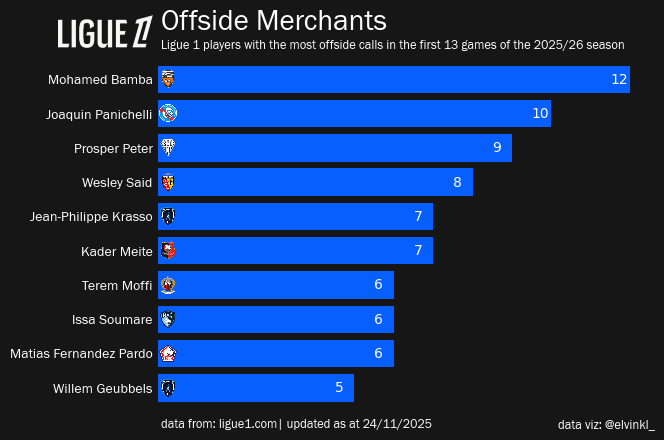

In [33]:
Ligue1_logo = Image.open(urlopen("https://ligue1.com/images/Logo_Ligue1_bis.webp"))

offsides_10=offsides_10.sort_values(by=['offsides'], ascending=True).sort_index(ascending=False) 


fig, ax = plt.subplots() 
fig.set_facecolor("#161616") 
ax.set_facecolor("#161616") 
ax.barh(offsides_10['player'],offsides_10['offsides'], color="#085fff") 
plt.xticks([]) 
ax.tick_params(axis='y', length=0, colors='white', labelfontfamily='Franklin Gothic Book') 
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_visible(False) 
ax.spines['left'].set_visible(False) 

for i, value in enumerate(offsides_10['offsides']): 
    ax.text(value-.5, i, str(value), va='center', color='white')

for index, row in offsides_10.iterrows():
    ab = AnnotationBbox(getImage(row['path']), (0.25,9-index),frameon=False)
    ax.add_artist(ab)

logo = add_image(Ligue1_logo, fig, -0.03,.84,.15,.15)

TITLE = "Offside Merchants"
SUBTITLE = "Ligue 1 players with the most offside calls in the first 13 games of the 2025/26 season"
data_source = "ligue1.com"
twitter_handle = "@elvinkl_"

fig.text(.13,.92,TITLE, size=21, color='white', weight='bold', family='Franklin Gothic Book')
fig.text(.13,.88, SUBTITLE, size=9, color='white', family='Franklin Gothic Book')
fig.text(.13,.09, f"data from: {data_source}| updated as at 24/11/2025", size=9, color='white', family='Franklin Gothic Book')
fig.text(.75,.09, f"data viz: {twitter_handle}", size=9, color='white', family='Franklin Gothic Book')